# Feed Forward Neural Network 

A feed forward neural network is an artificial neural network in which the connections between nodes does not form a cycle. The opposite of a feed wofard neural network is a recurrent neural network, in which certain pathways are cycled. The feed forward model is the simplest form of neurl network as information is only processed in one direction. While data may pass through multiple hidden nodes, it always moves in one direction and never backwards. 

In this tutorial, we will use everything we learned previously and put it together using the `MNIST` dataset. The `MNIST` dataset is used for recognizing hand-written digits. 

Our steps for this tutorial look like: 

* Loading the MNIST data
* DataLoader and Transformation
* Multilayer Neural Net, Activation Function
* Loss and Optimizer
* Training Loop (Batch Training)
* Model Evaluation - Calculating Accuracy
* GPU Support 

Now, to import our modules.

In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

Now, to do our device configuration. So, this will determine whether we are using a GPU or a CPU. Later, we will push our tensors to the device. This will guarantee it will run on the GPU, if it is supported.

In [5]:
#configuring the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Now, to define hyperparameters. As a note, remember:

* epoch = 1 complete forward and backward pass of ALL training samples
* batch_size = number of training samples in one forward and backward pass
* number of iterations = number of passes, each uses the *batch_size* number of samples

In [7]:
input_size = 784 #this is because our images have the size 28x28 = 784 - we will flatten the array to be a 1D tensor later
hidden_size = 100 #can also try out different sizes here
num_classes = 10 #have 10 different classes - digits from 0 to 9
num_epochs = 2 #can be higher, but the training will take longer
batch_size = 100
learning_rate = 0.001

No we will import our famous MNIST data.

In [9]:
#training data - we are converting it to tensor and downloading it
train_dataset = torchvision.datasets.MNIST(root = './data', train = True, 
                                           transform = transforms.ToTensor(), download = True)

#testing data - we are converting it to tensor and downloading it
test_dataset = torchvision.datasets.MNIST(root = './data', train = False, 
                                           transform = transforms.ToTensor())

#train loader - will create an iterable for automatic batching
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

#test loader - will create an iterable for automatic batching 
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)

Now, let's look at one batch of our data.

In [12]:
#the iter() method returns an iterator of the given object
#An iterator is an object that contains a countable number of values. 
#An iterator is an object that can be iterated upon, meaning that you can traverse through all the values.
#It seems that, in this situation, we are just getting one batch out of the several that there are to examine it
examples = iter(train_loader)

#creating a new iterator each time and extracting the first object
samples, labels = examples.next()
print(samples.shape, labels.shape)

torch.Size([100, 1, 28, 28]) torch.Size([100])


So, the size is (100, 1, 28, 28). This is because the batch size is 100 (100 samples in the batch), 1 is because we only have 1 channel, and 28,28 is the image array which is 28x28. Our label is a tensor of size 100, so for each class label, we have 1 value here. 

Now, let's plot this to see how it's looking - this will show us the hand-written digits in the data.

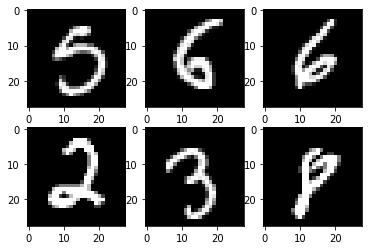

In [15]:
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(samples[i][0], cmap = 'gray')
plt.show()

Now we want to classify these digits. We are going to have a fully connected neural network with one hidden layer.

In [16]:
#creating a class for neural net
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size) #linear layer - input size is input and output is hidden size
        self.relu = nn.ReLU() #activation function
        self.l2 = nn.Linear(hidden_size, num_classes) #second linear layer - input is hidden size and output is num classes
        
    def forward(self, x):
        out = self.l1(x) #first linear layer
        out = self.relu(out) #hidden layer
        out = self.l2(out) #second linear layer 
        #we do not need an activation function (softmax because it is multiclass classification) - 
        #we will see that we will use cross-entropy loss - this will apply the softmax for us
        return out

#defining our model
model = NeuralNet(input_size, hidden_size, num_classes).to(device)

Now, we will create our loss and optimizer.

In [19]:
#loss 
criterion = nn.CrossEntropyLoss() #this will apply the softmax for us

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Now to do the training loop. As a note:

* Epoch - An epoch is a single pass through our full training data(60,000 images). An epoch consists of training steps, which is nothing but the number of batches passed to the model until all the training data is covered. 

It could be expressed as number of training steps = number of training records/batch size, which is 60000 (training samples) / 100 (batch size) = 600 (steps) in our case. We will have 600 steps per epoch. We'll train the model for 2 epochs- the model will see the full training data exactly 2 times.

In [26]:
#first define the number of total steps
n_total_steps = len(train_loader)
print(n_total_steps)

#training loop

#looping over epochs
for epoch in range(num_epochs): 
    
    #looping over batches
    for i, (images, labels) in enumerate(train_loader): #enumerate function gives us the actual index
        #first, have to reshape the images because it is 100, 1, 28, 28 and input size is 784
        #thus our tensor needs the size 100 (batch size) and 784 (28x28)
        images = images.reshape(-1, 28*28).to(device) #we put -1 as the first dimension so tensor can find it out 
        #automatically for us
        labels = labels.to(device)
        
        #forward pass 
        outputs = model(images)
        #loss - takes the predicted values (outputs) and labels (actual values)
        loss = criterion(outputs, labels)
        
        #backward pass
        optimizer.zero_grad() #to empty the values in the gradient attribute
        #backpropagation
        loss.backward()
        #update step - update the parameters
        optimizer.step()
        
        if (i+1) % 100 == 0: #every 100th step we want to print information
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

600
Epoch [1/2], Step [100/600], Loss: 0.1159
Epoch [1/2], Step [200/600], Loss: 0.1017
Epoch [1/2], Step [300/600], Loss: 0.1480
Epoch [1/2], Step [400/600], Loss: 0.0304
Epoch [1/2], Step [500/600], Loss: 0.0788
Epoch [1/2], Step [600/600], Loss: 0.0992
Epoch [2/2], Step [100/600], Loss: 0.0893
Epoch [2/2], Step [200/600], Loss: 0.0708
Epoch [2/2], Step [300/600], Loss: 0.0314
Epoch [2/2], Step [400/600], Loss: 0.0374
Epoch [2/2], Step [500/600], Loss: 0.0507
Epoch [2/2], Step [600/600], Loss: 0.0969


Now, to create the test loop and evaluate the accuracy. 

In [29]:
#we do not want to compute the gradient for all the steps we do
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    #loop over batches in the test samples
    for images, labels in test_loader:
        #now we must reshape this
        images = images.reshape(-1, 28*28).to(device) #we put -1 as the first dimension so tensor can find it out 
        #automatically for us
        labels = labels.to(device)
        #calculate the predictions 
        outputs = model(images)
        
        #getting the actual predictions
        _, predicted = torch.max(outputs.data, 1) #torch.max() will return the value and index, but we are interested in the index
        #this is why we do not need the first actual value, hence the _,
        n_samples += labels.size(0) #give us the number of samples in the current batch
        n_correct += (predicted == labels).sum().item() #for each correct prediction, we will add +1
    
    #now, when the loop is done, we will calculate the total accuracy
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 97.05 %
